In [1701]:
import pandas as pd 
import numpy as np
import random

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

In [1702]:
df=pd.read_csv("Proc_f1_data.csv")

In [1703]:
df.head()

,resultId,raceId,year,round,grid,positionOrder,points,laps,milliseconds,fastestLapTime,...,circuitId,name_y,location,country,lat,lng,alt,date,target_finish,fastestLapTime_ms
0,2460,136,2002,13,11,4,3.0,77.0,NaN,NaN,...,11,McLaren,Budapest,Hungary,47.5789,19.24860,264,2002-08-18,1,NaN
1,11565,483,1981,1,23,21,0.0,16.0,0.0,NaN,...,43,McLaren,California,USA,33.7651,-118.18900,12,1981-03-15,0,NaN
2,18661,772,1958,8,0,26,0.0,0.0,0.0,0,...,20,Maserati,Nürburg,Germany,50.3356,6.94750,578,1958-08-03,0,0.0
3,25121,1058,2021,8,19,16,0.0,69.0,0.0,1:10.005,...,70,Haas F1 Team,Spielberg,Austria,47.2197,14.76470,678,2021-06-27,0,70005.0
4,8863,383,1988,12,0,30,0.0,0.0,0.0,0,...,14,Euro Brun,Monza,Italy,45.6156,9.28111,162,1988-09-11,0,0.0


In [1704]:
df_imp=df[['year','grid','milliseconds','laps','points','positionOrder','fastestLapTime','fastestLapSpeed','fastestLapTime_ms','driverRef','constructorRef','circuitId','target_finish']]

In [1705]:
df_imp

,year,grid,milliseconds,laps,points,positionOrder,fastestLapTime,fastestLapSpeed,fastestLapTime_ms,driverRef,constructorRef,circuitId,target_finish
0,2002,11,NaN,77.0,3.0,4,NaN,NaN,NaN,raikkonen,mclaren,11,1
1,1981,23,0.0,16.0,0.0,21,NaN,NaN,NaN,watson,mclaren,43,0
2,1958,0,0.0,0.0,0.0,26,0,0.000,0.0,ruttman,maserati,20,0
3,2021,19,0.0,69.0,0.0,16,1:10.005,222.052,70005.0,mick_schumacher,haas,70,0
4,1988,0,0.0,0.0,0.0,30,0,0.000,0.0,modena,eurobrun,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2006,22,0.0,70.0,0.0,12,1:13.700,210.480,73700.0,doornbos,red_bull,18,0
9996,2006,16,5719770.0,57.0,2.0,7,1:27.690,217.707,87690.0,barrichello,honda,1,1
9997,2016,16,0.0,49.0,0.0,17,1:37.619,217.248,97619.0,kevin_magnussen,renault,9,0
9998,1980,0,0.0,0.0,0.0,25,0,0.000,0.0,kennedy,shadow,43,0


In [1706]:
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               10000 non-null  int64  
 1   grid               10000 non-null  int64  
 2   milliseconds       9710 non-null   float64
 3   laps               9022 non-null   float64
 4   points             9586 non-null   float64
 5   positionOrder      10000 non-null  int64  
 6   fastestLapTime     3919 non-null   object 
 7   fastestLapSpeed    3623 non-null   float64
 8   fastestLapTime_ms  3919 non-null   float64
 9   driverRef          10000 non-null  object 
 10  constructorRef     10000 non-null  object 
 11  circuitId          10000 non-null  int64  
 12  target_finish      10000 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 1015.8+ KB


# Train Test Split

In [1707]:
X=df_imp[['year','grid','laps','driverRef','constructorRef','circuitId','fastestLapTime_ms','fastestLapSpeed']]
y=df_imp['target_finish']

In [1708]:
X_linear_regression=df_imp[['year','grid','laps','driverRef','constructorRef','circuitId','fastestLapSpeed','fastestLapTime_ms']].dropna()
y_linear_regression=df_imp['target_finish'].dropna()

In [1709]:
def tr_te_split(X, y, test_size=0.2, random_state=42):
    random.seed(random_state)
    n = len(X)
    test_count = int(n * test_size)

    indices = list(range(n))
    random.shuffle(indices)

    test_indices = indices[:test_count]
    train_indices = indices[test_count:]

    X_train = X.iloc[train_indices].reset_index(drop=True)
    X_test  = X.iloc[test_indices].reset_index(drop=True)
    y_train = y.iloc[train_indices].reset_index(drop=True)
    y_test  = y.iloc[test_indices].reset_index(drop=True)

    return X_train, X_test, y_train, y_test


In [1710]:
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.2, random_state=42)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = tr_te_split(X_linear_regression, y_linear_regression, test_size=0.2, random_state=42)


# Preprocessing

### Target Encoding

In [1711]:
encoder = TargetEncoder(cols=['driverRef', 'constructorRef','circuitId'])
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

In [1712]:
X_train_encoded = X_train_encoded.astype(float)
X_test_encoded = X_test_encoded.astype(float)


In [1713]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               8000 non-null   float64
 1   grid               8000 non-null   float64
 2   laps               7218 non-null   float64
 3   driverRef          8000 non-null   float64
 4   constructorRef     8000 non-null   float64
 5   circuitId          8000 non-null   float64
 6   fastestLapTime_ms  3142 non-null   float64
 7   fastestLapSpeed    2902 non-null   float64
dtypes: float64(8)
memory usage: 500.1 KB


### Encoding for Linear_reg

In [1714]:
encoder = TargetEncoder(cols=['driverRef', 'constructorRef','circuitId'])
X_train_encoded_lin = encoder.fit_transform(X_train_lin, y_train_lin)
X_test_encoded_lin = encoder.transform(X_test_lin)
X_train_encoded_lin = X_train_encoded_lin.astype(float)
X_test_encoded_lin = X_test_encoded_lin.astype(float)
X_train_encoded_lin = X_train_encoded_lin.replace([None], np.nan)
X_test_encoded_lin = X_test_encoded_lin.replace([None], np.nan)

X_train_encoded_lin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2696 entries, 0 to 2695
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               2696 non-null   float64
 1   grid               2696 non-null   float64
 2   laps               2696 non-null   float64
 3   driverRef          2696 non-null   float64
 4   constructorRef     2696 non-null   float64
 5   circuitId          2696 non-null   float64
 6   fastestLapSpeed    2696 non-null   float64
 7   fastestLapTime_ms  2696 non-null   float64
dtypes: float64(8)
memory usage: 168.6 KB


### Scaling for Linear_reg

In [1715]:
numerical_features = ['year', 'grid','laps','fastestLapSpeed','fastestLapTime_ms']

scaler = StandardScaler()
X_train_encoded_scaled_lin=X_train_encoded_lin
X_test_encoded_scaled_lin=X_test_encoded_lin

X_train_encoded_scaled_lin[numerical_features] = scaler.fit_transform(X_train_encoded_lin[numerical_features])

X_test_encoded_scaled_lin[numerical_features] = scaler.transform(X_test_encoded_lin[numerical_features])



# Model Training

### Logistic Regression

In [1716]:
y.value_counts(normalize=True)


target_finish
0    0.7105
1    0.2895
Name: proportion, dtype: float64

In [1717]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_encoded_lin_res, y_train_lin_res = smote.fit_resample(X_train_encoded_lin, y_train_lin)


In [1718]:
log_model = LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced')
log_model.fit(X_train_encoded_lin_res, y_train_lin_res)

y_pred_log = log_model.predict(X_test_encoded_lin)

### Decision Tree Classifier

In [1719]:
dt_model = DecisionTreeClassifier(
    max_depth=None,       
    min_samples_split=2,  
    random_state=42
)

dt_model.fit(X_train_encoded, y_train)


y_pred_dt = dt_model.predict(X_test_encoded)

### Random Forest Classifier

In [1720]:
rf_model = RandomForestClassifier(
    n_estimators=200,     
    max_depth=None,      
    random_state=42,
    n_jobs=-1               
)
rf_model.fit(X_train_encoded, y_train)
y_pred_rfc = rf_model.predict(X_test_encoded)

### XGBoost Classifier

In [1721]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,    
    max_depth=6,          
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan,      
    eval_metric='logloss',
    random_state=42
)


xgb_model.fit(X_train_encoded, y_train)


y_pred_xgb = xgb_model.predict(X_test_encoded)

# Accuracy Comparision

In [1722]:
def acc(y_true, y_pred):
    correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
    return correct / len(y_true)


In [1723]:
def conf_mat(y_true, y_pred):
    TP = sum((yt==1 and yp==1) for yt, yp in zip(y_true, y_pred))
    TN = sum((yt==0 and yp==0) for yt, yp in zip(y_true, y_pred))
    FP = sum((yt==0 and yp==1) for yt, yp in zip(y_true, y_pred))
    FN = sum((yt==1 and yp==0) for yt, yp in zip(y_true, y_pred))
    
    return [[TN, FP],
            [FN, TP]]


In [1724]:
def class_rep(y_true, y_pred):
    cm = conf_mat(y_true, y_pred)
    TN, FP = cm[0]
    FN, TP = cm[1]
    

    precision_1 = TP / (TP + FP) if TP + FP != 0 else 0
    recall_1 = TP / (TP + FN) if TP + FN != 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if precision_1 + recall_1 != 0 else 0
    
    
    precision_0 = TN / (TN + FN) if TN + FN != 0 else 0
    recall_0 = TN / (TN + FP) if TN + FP != 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if precision_0 + recall_0 != 0 else 0
    
    return {
        0: {'precision': precision_0, 'recall': recall_0, 'f1': f1_0},
        1: {'precision': precision_1, 'recall': recall_1, 'f1': f1_1}
    }


### Accuracy of Logistic Regression

In [1725]:
acc_lr = acc(y_test_lin, y_pred_log)
cm_lr = conf_mat(y_test_lin, y_pred_log)

print("Accuracy:", acc_lr)
print("\nConfusion Matrix:")
print(f"TN:{cm_lr[0][0]}  FP:{cm_lr[0][1]}\nFN:{cm_lr[1][0]}  TP:{cm_lr[1][1]}")
print("\nClassification Report:")

metrics = class_rep(y_test, y_pred_log)
print("Class 0:", metrics[0])
print("Class 1:", metrics[1])

Accuracy: 0.5081723625557206

Confusion Matrix:
TN:256  FP:202
FN:129  TP:86

Classification Report:
Class 0: {'precision': 0.6805194805194805, 'recall': 0.5634408602150538, 'f1': 0.6164705882352941}
Class 1: {'precision': 0.2951388888888889, 'recall': 0.40865384615384615, 'f1': 0.34274193548387094}


### Accuracy of Random Forest

In [1726]:
acc_rf = acc(y_test, y_pred_rfc)
cm_rf = conf_mat(y_test, y_pred_rfc)

print("Accuracy:", acc_rf)
print("\nConfusion Matrix:")
print(f"TN:{cm_rf[0][0]}  FP:{cm_rf[0][1]}\nFN:{cm_rf[1][0]}  TP:{cm_rf[1][1]}")
print("\nClassification Report:")

metrics = class_rep(y_test, y_pred_rfc)
print("Class 0:", metrics[0])
print("Class 1:", metrics[1])

Accuracy: 0.865

Confusion Matrix:
TN:1292  FP:115
FN:155  TP:438

Classification Report:
Class 0: {'precision': 0.8928818244644091, 'recall': 0.9182658137882018, 'f1': 0.905395935529082}
Class 1: {'precision': 0.7920433996383364, 'recall': 0.7386172006745363, 'f1': 0.7643979057591623}


### Accuracy of Decision Tree

In [1727]:
acc_dt = acc(y_test, y_pred_dt)
cm_dt = conf_mat(y_test, y_pred_dt)

print("Accuracy:", acc_dt)
print("\nConfusion Matrix:")
print(f"TN:{cm_dt[0][0]}  FP:{cm_dt[0][1]}\nFN:{cm_dt[1][0]}  TP:{cm_dt[1][1]}")
print("\nClassification Report:")

metrics = class_rep(y_test, y_pred_dt)
print("Class 0:", metrics[0])
print("Class 1:", metrics[1])

Accuracy: 0.824

Confusion Matrix:
TN:1225  FP:182
FN:170  TP:423

Classification Report:
Class 0: {'precision': 0.8781362007168458, 'recall': 0.8706467661691543, 'f1': 0.8743754461099216}
Class 1: {'precision': 0.6991735537190082, 'recall': 0.7133220910623946, 'f1': 0.7061769616026712}


### Accuracy of XGBoost Model

In [1728]:
acc_xgb = acc(y_test, y_pred_xgb)
cm_xgb = conf_mat(y_test, y_pred_xgb)

print("Accuracy:", acc_xgb)
print("\nConfusion Matrix:")
print(f"TN:{cm_xgb[0][0]}  FP:{cm_xgb[0][1]}\nFN:{cm_xgb[1][0]}  TP:{cm_xgb[1][1]}")
print("\nClassification Report:")

metrics = class_rep(y_test, y_pred_xgb)
print("Class 0:", metrics[0])
print("Class 1:", metrics[1])

Accuracy: 0.905

Confusion Matrix:
TN:1318  FP:89
FN:101  TP:492

Classification Report:
Class 0: {'precision': 0.9288231148696265, 'recall': 0.9367448471926084, 'f1': 0.9327671620665251}
Class 1: {'precision': 0.846815834767642, 'recall': 0.8296795952782462, 'f1': 0.838160136286201}


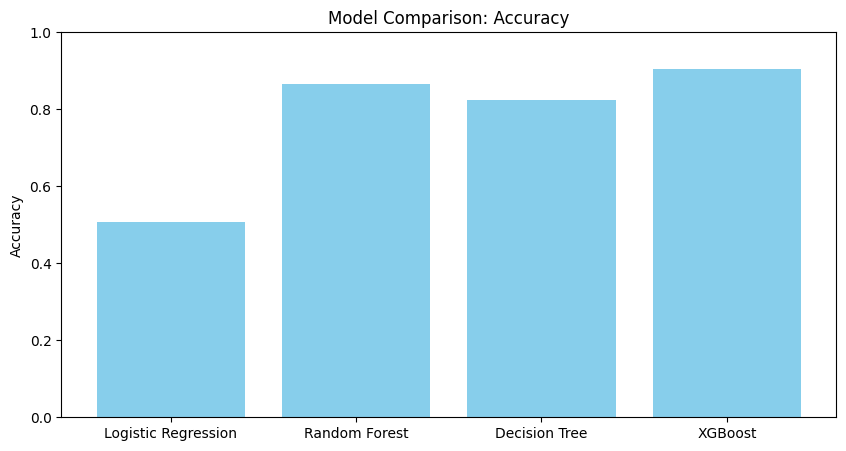

In [1729]:
models = ['Logistic Regression', 'Random Forest', 'Decision Tree', 'XGBoost']

accuracies = [
    acc(y_test_lin, y_pred_log),
    acc(y_test, y_pred_rfc),
    acc(y_test, y_pred_dt),
    acc(y_test, y_pred_xgb)
]
plt.figure(figsize=(10,5))
plt.bar(models, accuracies, color='skyblue')
plt.title("Model Comparison: Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


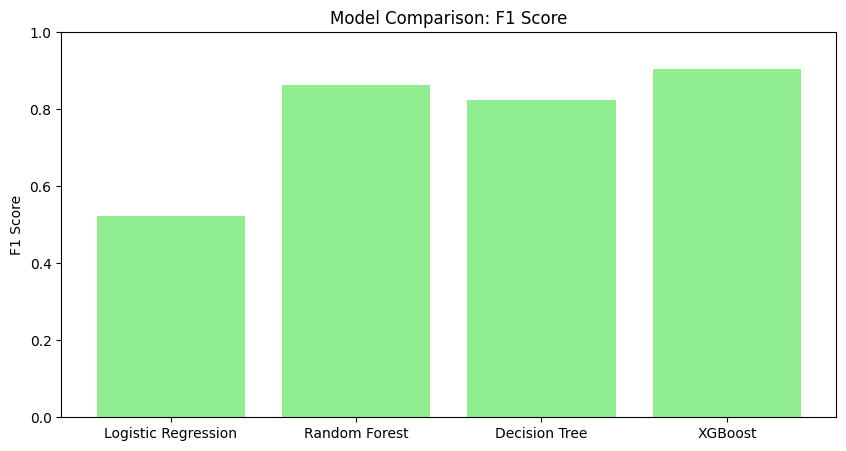

In [1730]:
f1_scores = [
    f1_score(y_test_lin, y_pred_log, average='weighted'),
    f1_score(y_test, y_pred_rfc, average='weighted'),
    f1_score(y_test, y_pred_dt, average='weighted'),
    f1_score(y_test, y_pred_xgb, average='weighted')
]

plt.figure(figsize=(10,5))
plt.bar(models, f1_scores, color='lightgreen')
plt.title("Model Comparison: F1 Score")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.show()

# Important features 

In [1731]:
importances = xgb_model.feature_importances_


In [1732]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


             Feature  Importance
3          driverRef    0.261558
2               laps    0.157439
1               grid    0.133157
4     constructorRef    0.126298
6  fastestLapTime_ms    0.089462
5          circuitId    0.081382
7    fastestLapSpeed    0.080869
0               year    0.069834


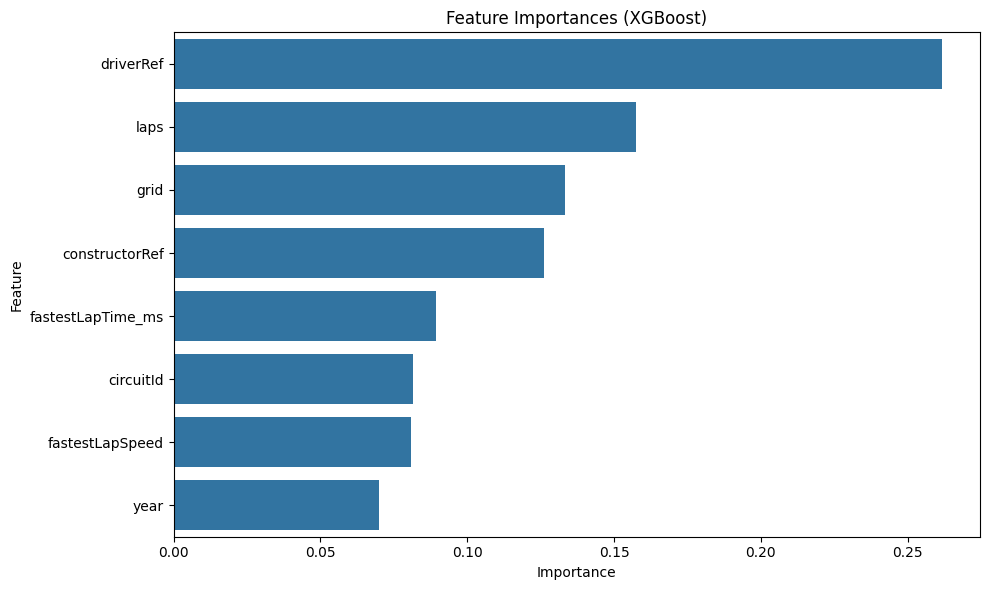

In [1733]:
top_features = feature_importance_df

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()
